In [2]:
import requests
from bs4 import BeautifulSoup
from retry import retry

import numpy as np
import re
import pandas as pd
from datetime import datetime

In [13]:
# SUUMOを東京都23区のみ指定して検索して出力した画面のurl(ページ数フォーマットが必要)
url = "https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi={{2}}&page={}"


# リクエストがうまく行かないパターンを回避するためのやり直し
@retry(tries=3, delay=10, backoff=2)
def load_page(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content, 'html.parser')
    return soup

In [54]:
# 面積を抽出する関数
def extract_area(text):
    match = re.search(r'(\d+(\.\d+)?)m2', text)
    if match:
        return float(match.group(1))
    return None

extract_area("50.00m2　（15.13m2）")

def extract_name(text):
    return text.split()[0]

extract_name("給田西住宅\u3000１号棟")

def extract_price(text):
    text = text.strip()
    match = re.search(r'((\d+)億)?\s*((\d+)万)?', text)
    if match:
        oku = int(match.group(2)) * 100000000 if match.group(2) else 0
        man = int(match.group(4)) * 10000 if match.group(4) else 0
        return oku + man
    return None

print(extract_price("\n1億4700万円\n"))  # Output: 147000000
print(extract_price("1億5000万円"))      # Output: 150000000
print(extract_price("1億円"))            # Output: 100000000
print(extract_price("\n5000万円"))         # Output: 50000000

147000000
150000000
100000000
50000000


In [55]:
def calculate_age(built_date):
    # 現在の年と月を取得
    current_date = datetime.now()
    current_year = current_date.year
    current_month = current_date.month

    # built_dateを年と月に分割
    match = re.search(r'(\d+)年(\d+)月', built_date)
    if match:
        built_year = int(match.group(1))
        built_month = int(match.group(2))
    else:
        return None,None
    
    # 築年数を計算
    age_years = current_year - built_year
    age_months = current_month - built_month

    # 月の差がマイナスの場合、年から1を引き、月に12を足す
    if age_months < 0:
        age_years -= 1
        age_months += 12

    return age_years,age_months

a,b=calculate_age("2021年5月")

print(a,b)

3 7


In [56]:
soup = load_page(url.format(2))

In [59]:
def get_estate_data_suumo():
    # SUUMOを東京都23区のみ指定して検索して出力した画面のurl(ページ数フォーマットが必要)
    url = "https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi={{2}}&page={}"
    ESTATES_MAX=30
    info={"name":[],
          "price":[],
          "address":[],
          "area":[],
          "age_years":[],
          "age_months":[],
          "price per unit area":[]
          }

    for page in range(1,2):
        soup = load_page(url.format(page))
        estates_groups = soup.find("div",class_='property_unit_group')
        estates = estates_groups.find_all('div', class_='property_unit')

        for i in range(ESTATES_MAX):
            estate=estates[i].find_all('div', class_='dottable-line')

            
            name_text=estate[0].find_all("dd")[0].text
            info["name"].append(extract_name(name_text))
            price_text=estate[1].find_all("dd")[0].text

            info["price"].append(extract_price(price_text))
            info["address"].append(estate[2].find_all("dd")[0].text)
            area_text=estate[3].find_all("dd")[0].text
            info["area"].append(extract_area(area_text))
            built_date=estate[4].find_all("dd")[1].text
            age_years,age_months=calculate_age(built_date)
            info["age_years"].append(age_years)
            info["age_months"].append(age_months)
            info["price per unit area"].append(float(info["price"][-1])/float(info["area"][-1])*3.30578)

    return pd.DataFrame(info)

data=get_estate_data_suumo()

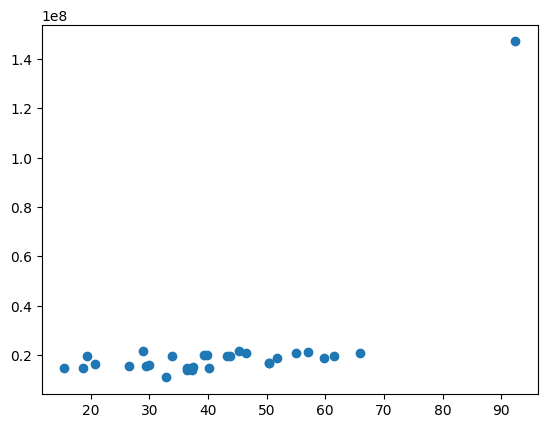

In [60]:
import matplotlib.pyplot as plt

plt.scatter(data["area"].values,data["price"].values)

0     92.36
1     32.93
2     36.45
3     37.27
4     15.51
5     36.45
6     18.62
7     40.14
8     37.37
9     29.48
10     26.6
11    29.88
12    20.83
13    50.34
14    50.34
15    51.74
16    59.83
17    19.43
18    61.56
19    43.74
20    43.33
21    33.89
22     39.4
23    39.76
24       55
25    65.88
26    46.48
27     57.1
28    28.86
29    45.36
Name: area, dtype: object

In [58]:
estates_groups = soup.find("div",class_='property_unit_group')
estates = estates_groups.find_all('div', class_='property_unit')

In [ ]:
for j in range(6):
    a=estates[1].find_all('div', class_='dottable-line')[j].find_all("dd")

    a_text=[item.text for item in a]

    print(a_text)
    print("--------------------------")

In [79]:
a='給田西住宅\u3000１号棟'

a.split("\u")


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: truncated \uXXXX escape (1715940244.py, line 3)

In [ ]:
child_divs = div_estates.find_all('div', class_='property_unit')
len(child_divs)

In [ ]:
child_texts = [child.text for child in child_divs]

In [ ]:
child_divs[0]